In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *




process_gen_modes=["instruct"]

dfs_by_model,processGens,(root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric)= get_dfs_by_model(process_gen_modes, recalculate_everything=False)
for key, df in dfs_by_model.items():
    for col_name in ["Helpfulness", "Completeness", "Understandability","Conciseness", 'Harmlessness', "Interestingness"]:
        df[col_name]=df[col_name].replace(0, np.nan)
examples_df = pd.concat(list(dfs_by_model.values()))

task_names=list(df["task_name"].unique())


# processGens=ProcessGens()
# do_norm_analysis=True
# processGens.init_with_mode(process_gen_modes)
# root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
# examples_df, completions_df=get_dfs(processGens)

# #self-instruct and vicuna

# dfs_by_model={}

# for model_name in examples_df['model'].unique():
#     filtered_df = examples_df[examples_df["model"]==model_name]
#     dfs_by_model[model_name]=filtered_df

# all_dfs_by_model=dfs_by_model
# if(len(models)>1):
    # all_dfs_by_model["all_models"]=examples_df

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.




----------------
 NOTE: ONLY PRINTING 4 tasks ----------------

mode is instructtask_names is ['self_instruct_num_respondents_1_', 'anthropic_hh_rlhf_subset_hh_num_respondents_1_', 'vicuna_num_respondents_1_', 'koala_num_respondents_1_', 'anthropic_hh_rlhf_subset_red_team_num_respondents_1_', 'grammar_path_src_helm_benchmark_scenarios_best_chatgpt_prompts.yaml_tags_num_respondents_1_']


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['Qwen_Qwen3_8B'] 
 	 custom_metrics[]
 	 task_names ['self_instruct_num_respondents_1_', 'anthropic_hh_rlhf_subset_hh_num_respondents_1_', 'vicuna_num_respondents_1_', 'koala_num_respondents_1_', 'anthropic_hh_rlhf_subset_red_team_num_respondents_1_', 'grammar_path_src_helm_benchmark_scenarios_best_chatgpt_prompts.yaml_tags_num_respondents_1_'] 
 	 suite_name sample_100_eval_100_first_inst_0 
 	 instance_metrics []
   example_themis  Helpfulness  Completeness  Understandability  Conciseness  \
0               1          NaN           4.0                5.0          5.0   
1               1          NaN           4.0                5.0          5.0   

   Harmlessness  Interestingness  beam_num                         task_name  \
0           NaN              1.0         1  self_instruct_num_respondents_1_   
1           NaN              1.0         1  self_instruct_num_respondents_1_   

           model  ex

In [3]:
# for compare_metric in ["Helpfulness", "Completeness", "Understandability","Conciseness", 'Harmlessness', "Interestingness"]:
#     df=examples_df

#     df["rank"]=100-df["example_idx"]
#     max_example_idx = examples_df["example_idx"].max()
#     plots_wide=1
#     num_models=len(dfs_by_model.keys())
#     plots_tall=math.ceil(num_models/plots_wide)

#     suptitle=""
#     axs=None
#     fig=None
#     xlabel="rank"
#     ylabel=compare_metric
#     groupby="rank"


#     grouped = df[[xlabel, ylabel]].groupby(groupby).mean().reset_index()
#     x=grouped[xlabel]
#     y=grouped[ylabel]

#     fig, ax = plt.subplots()

#     ax.scatter(x, y)
#     ax.set_ylabel(compare_metric)
#     ax.set_xlabel("Rank")
#     ax.set_title("Qwen 8B")



  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        

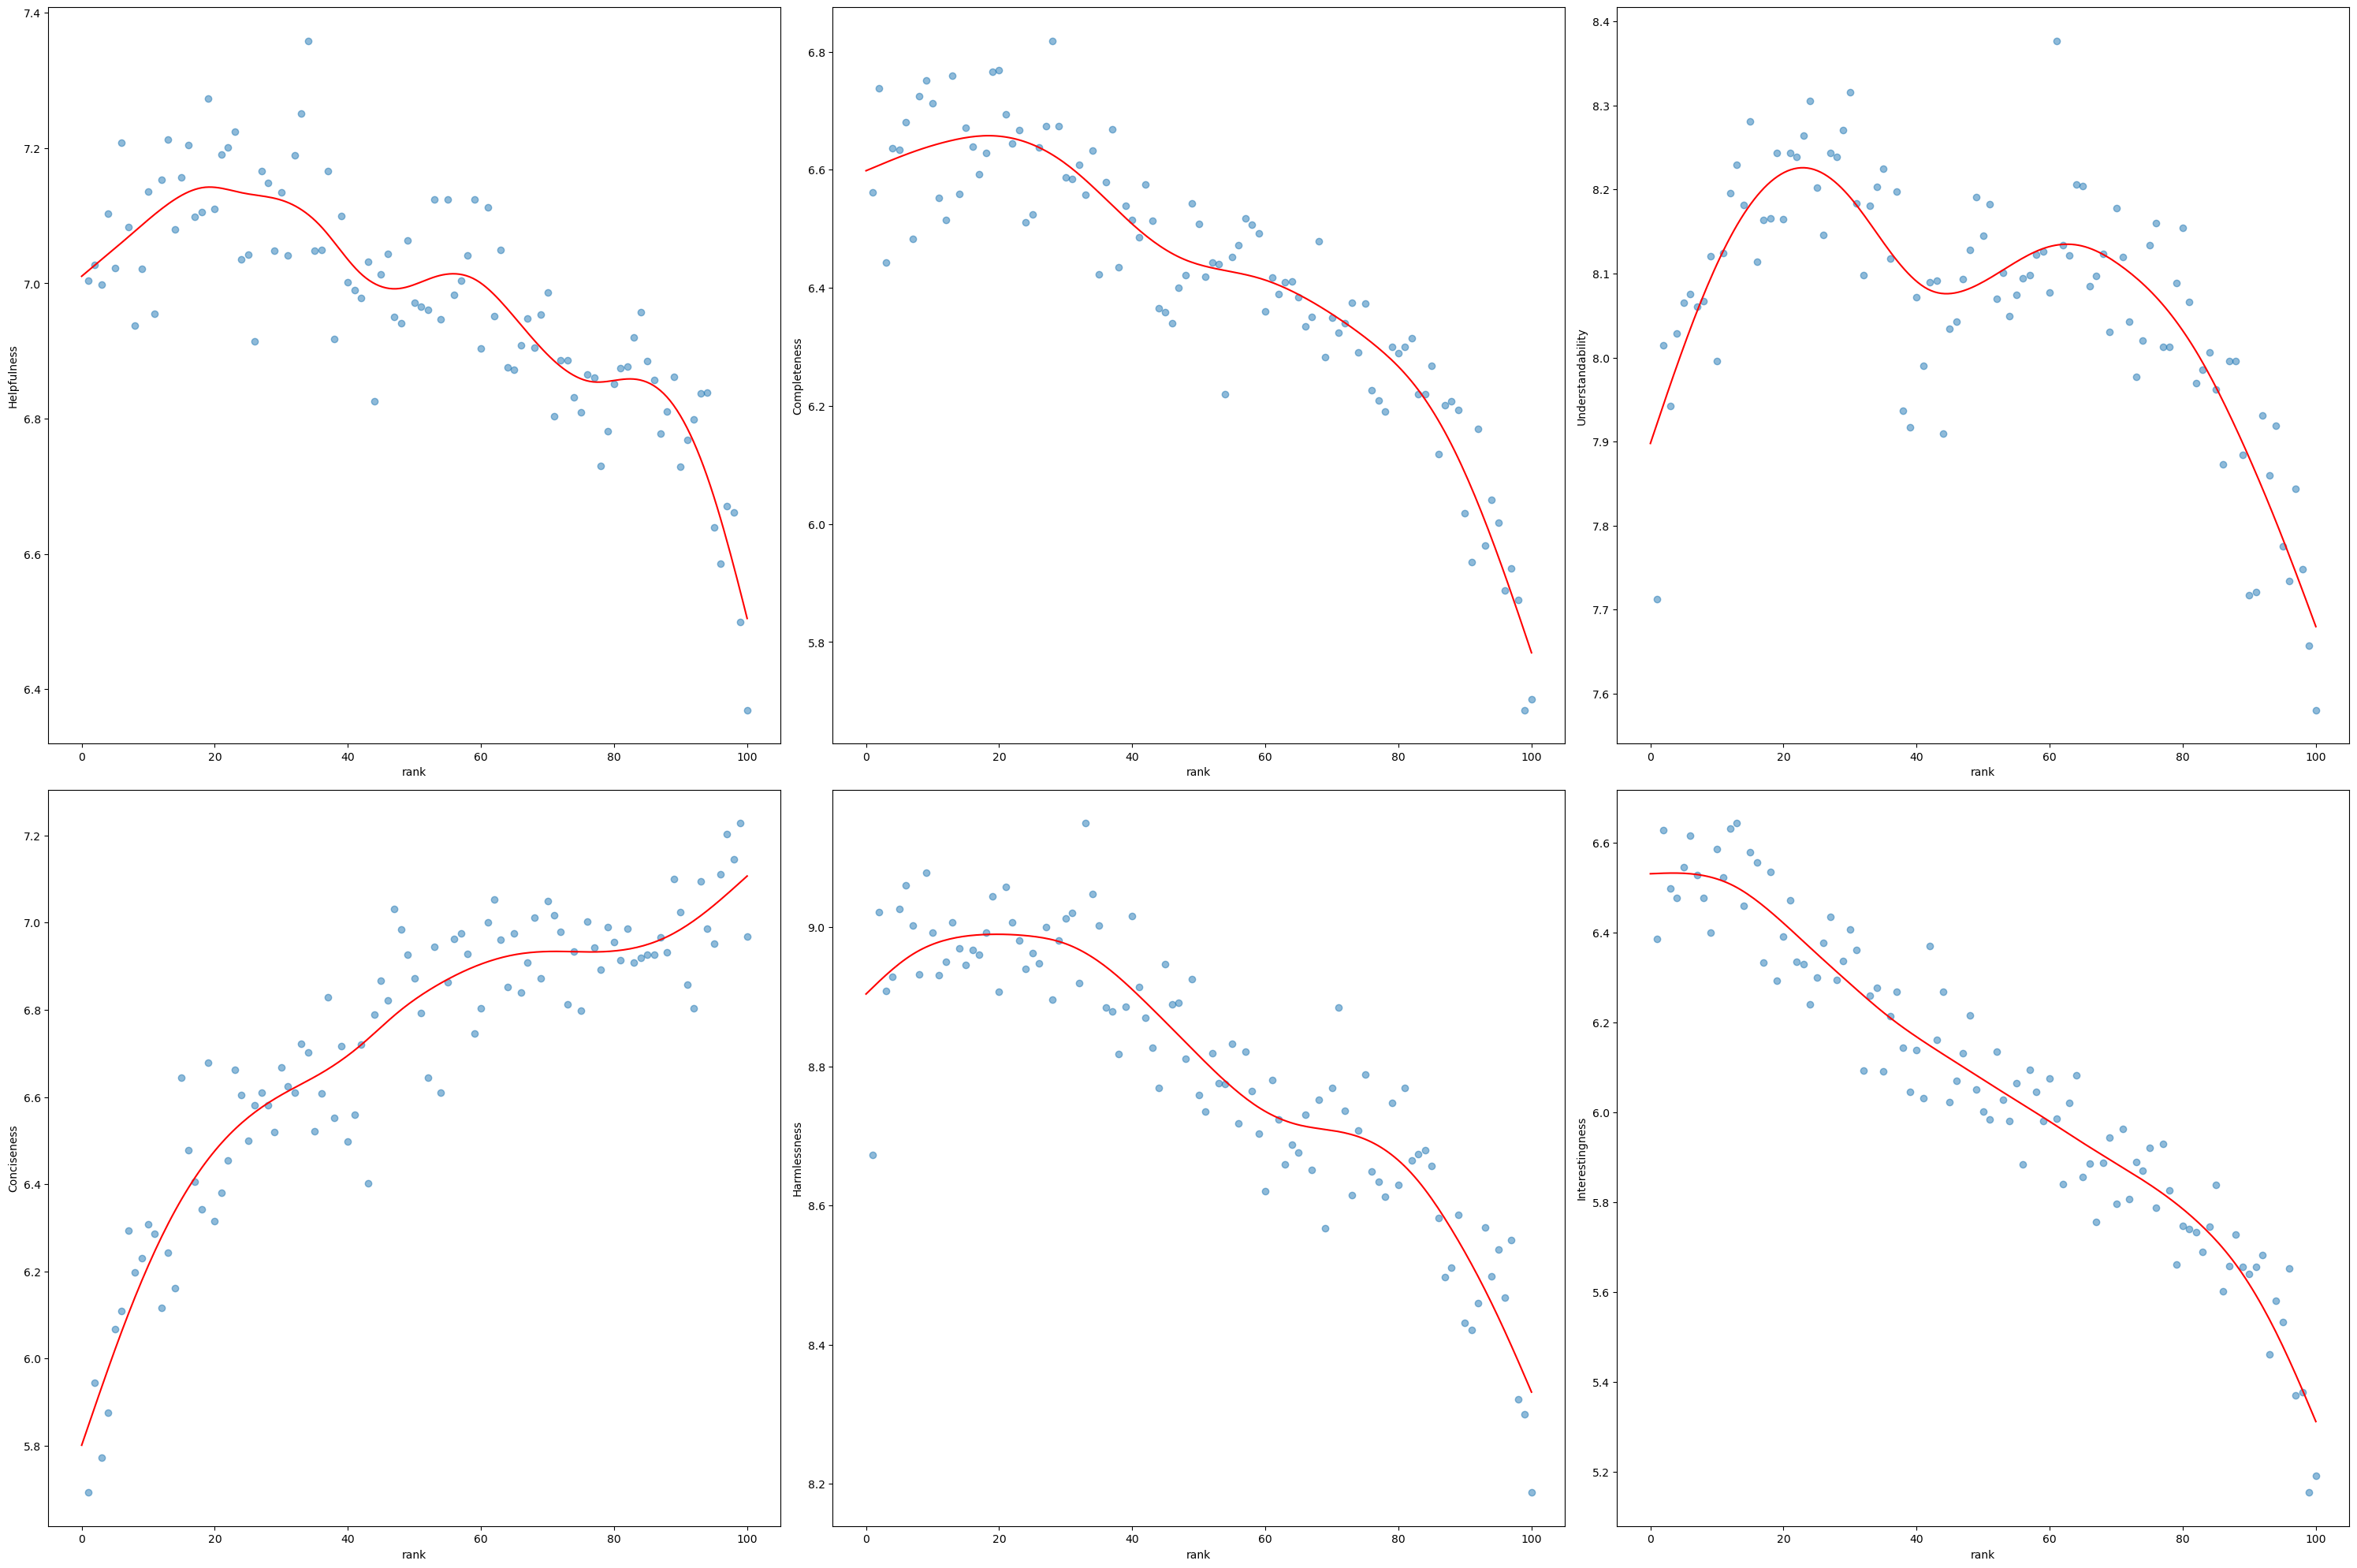

In [4]:
from pygam import LinearGAM, s
from sklearn.metrics import r2_score
    



#we want an array of tuples (title, df)





def plot_gam(df, compare_metric, ax):
    grouped = df.groupby("example_idx")[["rank", compare_metric]].mean()


    # Assuming df is your dataframe
    X = grouped["rank"].values.reshape(-1,1)
    y = grouped[compare_metric].values.reshape( -1)


    gam = LinearGAM(s(0)).gridsearch(X, y)
    # gam.summary()
    X_pred = np.linspace(0, 100,200).reshape(-1, 1)
    y_pred = gam.predict(X_pred)


    ax.scatter(X, y, label='Data', alpha=0.5)
    ax.plot(X_pred, y_pred, label='GAM Prediction', color='red')
    ax.set_xlabel('rank')
    ax.set_ylabel(compare_metric)
    return ax


# for compare_metric in ["Helpfulness", "Completeness", "Understandability","Conciseness", 'Harmlessness', "Interestingness"]:
#     plot_gam(df, compare_metric)





# def calculate_title():
#     readable_model=get_model_details(model_name)['name']
#     return f"{readable_model}: {suptitle}" if ax is None else readable_model





def create_plots(kwargs_array, graph_func, figsize=None):
    nrows=len(kwargs_array)
    ncols=max(len(s) for s in kwargs_array)

    if figsize is None:
        figsize=(nrows*5, ncols*5)
        print(f"figsize is {figsize}")
    _, axes=plt.subplots(nrows=nrows, ncols= ncols, figsize=figsize)
    
    for row, kwargs_vect in enumerate(kwargs_array):
        for col in range(ncols):
            ax=axes[row][col]
            if col < len(kwargs_vect):
                kwargs=kwargs_vect[col]
                
                kwargs["ax"]=ax
                # print(f"kwargs is {kwargs}")
                ax=graph_func(**kwargs)

                
                # ax.set_xlabel(None)
                # ax.set_ylabel(None)
            else:
                ax.axis('off')

        
    plt.tight_layout()



metrics_array=[["Helpfulness", "Completeness", "Understandability"],
            ["Conciseness", 'Harmlessness', "Interestingness"]]




kwargs_array= [[{"df":df, "compare_metric": themis_metric} for themis_metric in metrics_vect] for metrics_vect in metrics_array]

create_plots(kwargs_array, plot_gam, figsize=(30, 20))


/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_10052/4218407257.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(title='Metric')


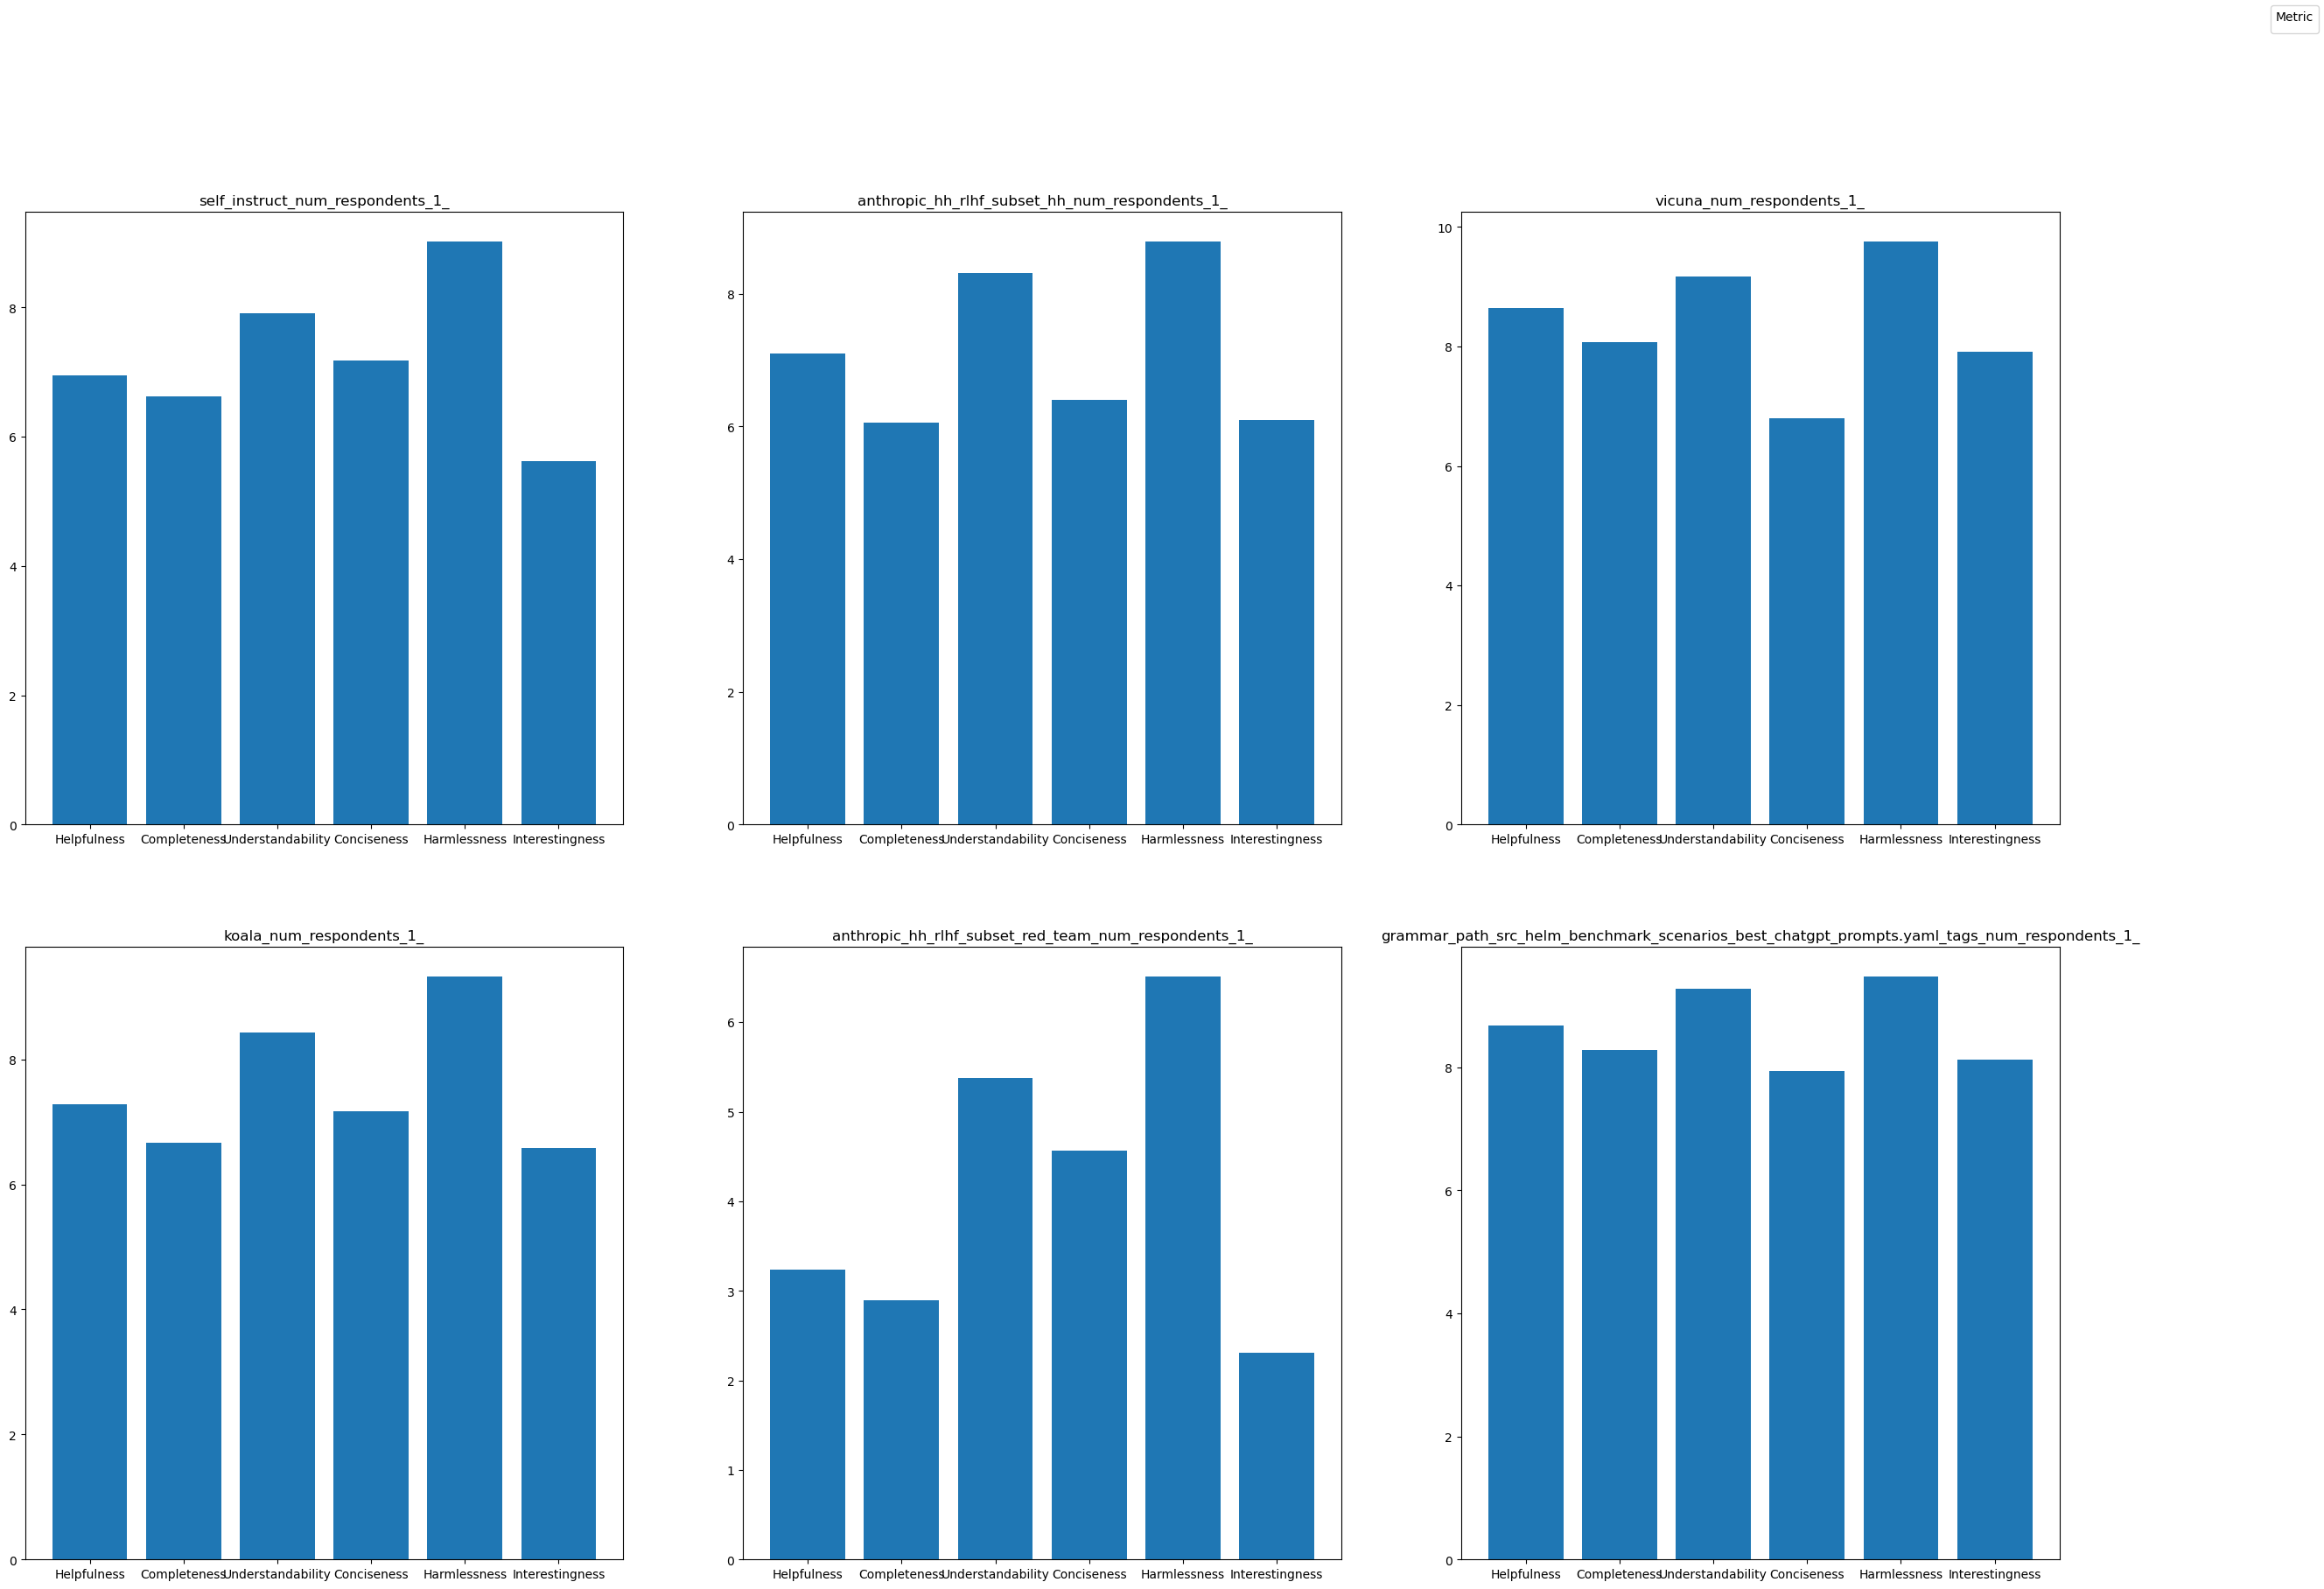

In [5]:


fig, axes = plt.subplots(2,3, figsize=(30,20))
themis_metrics=["Helpfulness", "Completeness", "Understandability","Conciseness", 'Harmlessness', "Interestingness"]
# for task_name in [task_names[0]]:
for idx, task_name in enumerate(task_names):

    row = idx % 3
    col = math.floor(idx / 3)
    ax=axes[col,row]

    filtered_df = df[df["task_name"]==task_name]
    bar_df=filtered_df[themis_metrics].mean()
    themis_vals = [bar_df[themis_metric] for themis_metric in themis_metrics ]

    ax.bar(themis_metrics, themis_vals)
    ax.set_title(task_name)
fig.legend(title='Metric')
    
    # plot_gam(df, compare_metric)